In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, GRU
from keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
import db
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



ModuleNotFoundError: No module named 'tensorflow'

In [2]:
seed = 13520039
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
conn = db.connect()

raw_data, colnames = db.get_data(conn)
conn.close()

In [4]:
train_data = pd.DataFrame(raw_data, columns=colnames)
train_data.drop(["id", "timestamp"], axis=1, inplace=True)
colnames = train_data.columns

In [5]:
train_data.shape

(360, 54)

In [6]:
import joblib 
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(train_data)
joblib.dump(sc, 'scaler.pkl')

['scaler.pkl']

In [7]:
# split for getting next timestep
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
# choose a number of time steps
n_steps = [30, 45, 60, 90, 120, 150, 180]
# split into samples
data = []
for res in n_steps:
    data.append(split_sequence(training_set_scaled, res))

print(len(data))

7


In [9]:
column_length = len(colnames)

In [10]:
data[2][0].shape

(300, 60, 54)

In [11]:
model_list = []
model_history_list = []
for i in range(len(n_steps)):
    model_list.append(Sequential())
    model_list[i].add(Bidirectional(LSTM(128, input_shape=(n_steps[i], 4), return_sequences=True)))
    model_list[i].add(Dropout(0.1))
    model_list[i].add(Bidirectional(LSTM(64, input_shape=(n_steps[i], 4), return_sequences=True)))
    model_list[i].add(Dropout(0.1))
    model_list[i].add(Bidirectional(LSTM(32, input_shape=(n_steps[i], 4))))
    model_list[i].add(Dropout(0.1))
    model_list[i].add(Dense(32, activation='relu'))
    model_list[i].add(Dense(len(colnames)))

    model_list[i].compile(
        optimizer="adam",
        loss="mse",
        metrics=[RootMeanSquaredError()])

    model_history_list.append(model_list[i].fit(data[i][0], data[i][1], epochs=48, batch_size=32))
    print("============================== ^^ Model 1 Timestep: " + str(n_steps[i]))

Epoch 1/48
11/11 [==============================] - 7s 30ms/step - loss: 0.3432 - root_mean_squared_error: 0.5858
Epoch 2/48
11/11 [==============================] - 1s 52ms/step - loss: 0.2629 - root_mean_squared_error: 0.5127
Epoch 3/48
11/11 [==============================] - 0s 22ms/step - loss: 0.1911 - root_mean_squared_error: 0.4371
Epoch 4/48
11/11 [==============================] - 0s 22ms/step - loss: 0.1317 - root_mean_squared_error: 0.3629
Epoch 5/48
11/11 [==============================] - 0s 20ms/step - loss: 0.0848 - root_mean_squared_error: 0.2911
Epoch 6/48
11/11 [==============================] - 0s 20ms/step - loss: 0.0545 - root_mean_squared_error: 0.2335
Epoch 7/48
11/11 [==============================] - 0s 20ms/step - loss: 0.0355 - root_mean_squared_error: 0.1884
Epoch 8/48
11/11 [==============================] - 0s 20ms/step - loss: 0.0246 - root_mean_squared_error: 0.1567
Epoch 9/48
11/11 [==============================] - 0s 19ms/step - loss: 0.0185 - root_m

In [12]:
model_2_list = []
model_2_history_list = []
for i in range(len(n_steps)):
    model_2_list.append(Sequential())
    model_2_list[i].add(GRU(128, input_shape=(n_steps[i], len(colnames)), return_sequences=True))
    model_2_list[i].add(Dropout(0.2))
    model_2_list[i].add(GRU(64, return_sequences=True))
    model_2_list[i].add(Dropout(0.2))
    model_2_list[i].add(GRU(64))
    model_2_list[i].add(Dropout(0.2))
    model_2_list[i].add(Dense(32, activation='relu'))
    model_2_list[i].add(Dense(len(colnames)))

    model_2_list[i].compile(
        optimizer="adam",
        loss="mse",
        metrics=[RootMeanSquaredError()])

    model_2_history_list.append(model_2_list[i].fit(data[i][0], data[i][1], epochs=48, batch_size=32))
    print("============================== ^^ Model 2 Timestep: " + str(n_steps[i]))

Epoch 1/48
11/11 [==============================] - 4s 48ms/step - loss: 0.2937 - root_mean_squared_error: 0.5420
Epoch 2/48
11/11 [==============================] - 0s 18ms/step - loss: 0.1855 - root_mean_squared_error: 0.4307
Epoch 3/48
11/11 [==============================] - 0s 18ms/step - loss: 0.1107 - root_mean_squared_error: 0.3328
Epoch 4/48
11/11 [==============================] - 0s 17ms/step - loss: 0.0704 - root_mean_squared_error: 0.2654
Epoch 5/48
11/11 [==============================] - 0s 16ms/step - loss: 0.0510 - root_mean_squared_error: 0.2258
Epoch 6/48
11/11 [==============================] - 0s 16ms/step - loss: 0.0391 - root_mean_squared_error: 0.1978
Epoch 7/48
11/11 [==============================] - 0s 16ms/step - loss: 0.0330 - root_mean_squared_error: 0.1817
Epoch 8/48
11/11 [==============================] - 0s 16ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690
Epoch 9/48
11/11 [==============================] - 0s 17ms/step - loss: 0.0237 - root_m

In [13]:
model_3_list = []
model_3_history_list = []
for i in range(len(n_steps)):
    model_3_list.append(Sequential())
    model_3_list[i].add(LSTM(128, input_shape=(n_steps[i], len(colnames)), return_sequences=True))
    model_3_list[i].add(Dropout(0.1))
    model_3_list[i].add(LSTM(64, input_shape=(n_steps[i], len(colnames)), return_sequences=True))
    model_3_list[i].add(Dropout(0.1))
    model_3_list[i].add(LSTM(32, input_shape=(n_steps[i], len(colnames))))
    model_3_list[i].add(Dropout(0.1))
    model_3_list[i].add(Dense(32, activation='relu'))
    model_3_list[i].add(Dense(len(colnames)))

    model_3_list[i].compile(
        optimizer="adam",
        loss="mse",
        metrics=[RootMeanSquaredError()])

    model_3_history_list.append(model_3_list[i].fit(data[i][0], data[i][1], epochs=48, batch_size=32))
    print("============================== ^^ Model 3 Timestep: " + str(n_steps[i]))

Epoch 1/48
11/11 [==============================] - 3s 17ms/step - loss: 0.3489 - root_mean_squared_error: 0.5907
Epoch 2/48
11/11 [==============================] - 0s 17ms/step - loss: 0.2444 - root_mean_squared_error: 0.4944
Epoch 3/48
11/11 [==============================] - 0s 17ms/step - loss: 0.1579 - root_mean_squared_error: 0.3973
Epoch 4/48
11/11 [==============================] - 0s 17ms/step - loss: 0.0990 - root_mean_squared_error: 0.3147
Epoch 5/48
11/11 [==============================] - 0s 17ms/step - loss: 0.0640 - root_mean_squared_error: 0.2530
Epoch 6/48
11/11 [==============================] - 0s 16ms/step - loss: 0.0461 - root_mean_squared_error: 0.2146
Epoch 7/48
11/11 [==============================] - 0s 17ms/step - loss: 0.0358 - root_mean_squared_error: 0.1893
Epoch 8/48
11/11 [==============================] - 0s 16ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733
Epoch 9/48
11/11 [==============================] - 0s 16ms/step - loss: 0.0231 - root_m

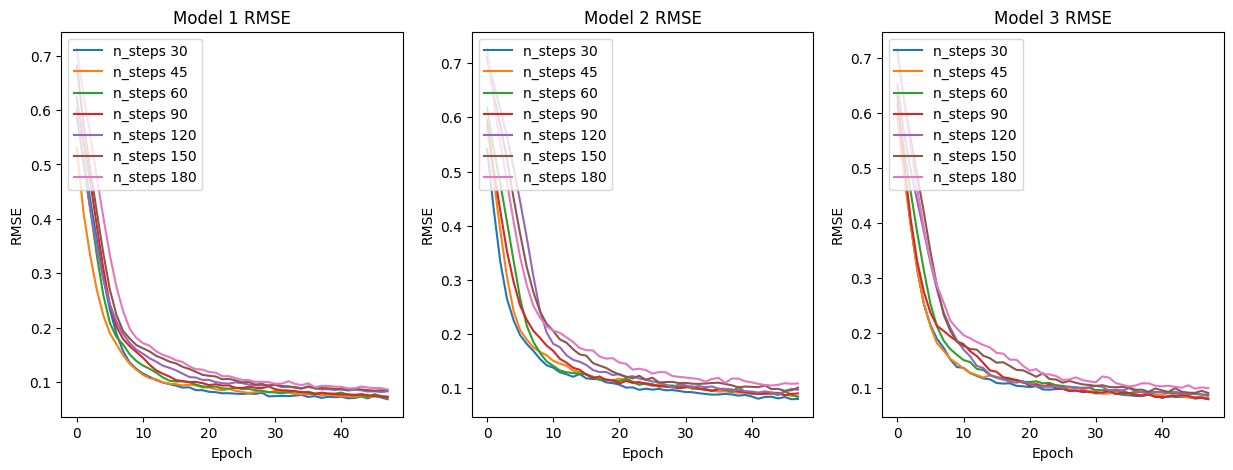

In [14]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(len(n_steps)):
    axs[0].plot(model_history_list[i].history['root_mean_squared_error'])
    axs[0].set_title('Model 1 RMSE')
    axs[0].set_ylabel('RMSE')
    axs[0].set_xlabel('Epoch')
    axs[0].legend([f'n_steps {n}' for n in n_steps], loc='upper left')

for i in range(len(n_steps)):
    axs[1].plot(model_2_history_list[i].history['root_mean_squared_error'])
    axs[1].set_title('Model 2 RMSE')
    axs[1].set_ylabel('RMSE')
    axs[1].set_xlabel('Epoch')
    axs[1].legend([f'n_steps {n}' for n in n_steps], loc='upper left')

for i in range(len(n_steps)):
    axs[2].plot(model_3_history_list[i].history['root_mean_squared_error'])
    axs[2].set_title('Model 3 RMSE')
    axs[2].set_ylabel('RMSE')
    axs[2].set_xlabel('Epoch')
    axs[2].legend([f'n_steps {n}' for n in n_steps], loc='upper left')

plt.show()


In [15]:
list(map(lambda x: x.history['root_mean_squared_error'][-1], model_history_list))

[0.0684487447142601,
 0.07109532505273819,
 0.07319220155477524,
 0.0723310336470604,
 0.08304185420274734,
 0.08548667281866074,
 0.0862332135438919]

In [16]:
list(map(lambda x: x.history['root_mean_squared_error'][-1], model_2_history_list))


[0.08017842471599579,
 0.084852434694767,
 0.0839976817369461,
 0.09049355238676071,
 0.09719870239496231,
 0.10088721662759781,
 0.10891380906105042]

In [17]:
list(map(lambda x: x.history['root_mean_squared_error'][-1], model_3_history_list))


[0.08016114681959152,
 0.08184824138879776,
 0.08827005326747894,
 0.0806782990694046,
 0.08607640862464905,
 0.09149190038442612,
 0.10039416700601578]

In [18]:
data[3][0][-1:]

array([[[0.82301716, 0.58333333, 0.82227955, ..., 0.75386655,
         0.85352781, 0.77527345],
        [0.82960317, 0.59675141, 0.82874877, ..., 0.76270437,
         0.86000159, 0.59396752],
        [0.83500516, 0.39724576, 0.83419046, ..., 0.76933274,
         0.86519792, 0.60059662],
        ...,
        [0.99999942, 0.37535311, 0.99845661, ..., 1.        ,
         0.99999654, 0.65760689],
        [0.99999968, 0.37535311, 0.9990281 , ..., 1.        ,
         0.99999758, 0.65760689],
        [0.99999988, 0.37535311, 0.99944197, ..., 1.        ,
         0.99999871, 0.65760689]]])

In [19]:
current_data = data[3][0][-1:]
predicted_data = []
for i in range(6):
    new_data = model_list[2].predict(current_data, verbose=0)
    transformed_new_data = sc.inverse_transform(new_data)[0]
    predicted_data.append(transformed_new_data)
    data_len = len(current_data[0])
    current_data = np.append(current_data[0][1:], new_data[0]).reshape(1, data_len, len(colnames))

In [20]:
df_predicted = pd.DataFrame(predicted_data, columns=colnames)

In [21]:
df_predicted

,compose_post_service_cpu,compose_post_service_memory,home_timeline_redis_cpu,home_timeline_redis_memory,home_timeline_service_cpu,home_timeline_service_memory,jaeger_cpu,jaeger_memory,media_frontend_cpu,media_frontend_memory,...,user_mongodb_cpu,user_mongodb_memory,user_service_cpu,user_service_memory,user_timeline_mongodb_cpu,user_timeline_mongodb_memory,user_timeline_redis_cpu,user_timeline_redis_memory,user_timeline_service_cpu,user_timeline_service_memory
0,7.224145,5.755875,3.884217,4.957106,6.950469,8.708526,2.804388,1273.291260,-0.005730,4.821746,...,8.349730,26.316612,0.768752,2.443023,14.104086,78.319748,5.283797,9.206219,11.322610,9.256845
1,7.224953,5.773155,3.886399,4.959656,6.960831,8.722076,2.805017,1273.895752,-0.005145,4.821826,...,8.354547,26.324804,0.770002,2.443316,14.120395,78.563019,5.282823,9.214780,11.343039,9.267729
2,7.228061,5.787170,3.888870,4.962127,6.970778,8.730538,2.806892,1274.454712,-0.005002,4.821853,...,8.358720,26.332064,0.770959,2.443477,14.132381,78.692070,5.281997,9.222080,11.363019,9.277288
3,7.229430,5.792837,3.889605,4.962759,6.973501,8.733400,2.807316,1274.337891,-0.004931,4.821864,...,8.360007,26.334841,0.771288,2.443272,14.137405,78.732475,5.280873,9.224155,11.370219,9.279716
4,7.230403,5.797872,3.890072,4.963170,6.975633,8.735287,2.807578,1274.183960,-0.004845,4.821867,...,8.361057,26.337017,0.771581,2.442990,14.141670,78.772354,5.279695,9.226313,11.376107,9.281267
5,7.231751,5.803581,3.890645,4.963740,6.978745,8.737540,2.808112,1274.109741,-0.004772,4.821866,...,8.362370,26.339588,0.771946,2.442740,14.146163,78.822838,5.278588,9.229729,11.383082,9.283088


In [25]:
model_list[3].summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 90, 256)           187392    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 90, 256)           0         
                                                                 
 bidirectional_10 (Bidirect  (None, 90, 128)           164352    
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 90, 128)           0         
                                                                 
 bidirectional_11 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                      

In [27]:
model_list[3].save("autoscaler_1_90_2.keras")

In [26]:
n_steps[3]

90

In [24]:
import tensorflow as tf
tf.__version__

'2.15.1'